# Final Project: Power of Parallel Computing in Car Brand Detection 

### Team Members : 
- **Angel Fernandes**
- **Anish Navale**

#### Import Neccessary Libraries and Initial Setup

In [1]:
# Importing essential libraries and setting up the environment for the project.
import os
CUDA_LAUNCH_BLOCKING = 1 # Ensures that CUDA operations are performed synchronously
import pandas as pd
import numpy as np

import random
import shutil

# visualizations libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
%matplotlib inline

import shutil
import os
from multiprocessing import Pool
import time

#### Data Overview and Exploration



In [2]:
base_dir= "RevisedData/data/"
classes = os.listdir(base_dir)
classes

['Acura',
 'Aston Martin',
 'Audi',
 'BMW',
 'Benz',
 'Cadillac',
 'Dodge',
 'FIAT',
 'Opel',
 'Porsche',
 'Renault',
 'Subaru',
 'Toyota',
 'Volkswagen']

In [3]:
VW_sample_data= r"RevisedData/data/Volkswagen"
print("VW images :\n" ,os.listdir(VW_sample_data)[:5])

BMW_sample_data= r"RevisedData/data/BMW"
print("\nBMW images :\n" ,os.listdir(BMW_sample_data)[:5])

AUDI_sample_data= r"RevisedData/data/Audi"
print("\nAUDI images :\n" ,os.listdir(AUDI_sample_data)[:5])

TOYOTA_sample_data= r"RevisedData/data/Toyota"
print("\nToyota images :\n" ,os.listdir(TOYOTA_sample_data)[:5])

VW images :
 ['000a79d5b6dd6d.jpg', '002635c660cc97.jpg', '00266f1000f701.jpg', '003a60f026053f.jpg', '0040b0de0daabd.jpg']

BMW images :
 ['0014f68100c1d3.jpg', '00199e658341a8.jpg', '00203ddf0f5cec.jpg', '00b1b467b2ed72.jpg', '00c7fd3a3e925c.jpg']

AUDI images :
 ['00041a0ef10aa2.jpg', '00218c89687073.jpg', '0047c8136dbb78.jpg', '004e5b647d24dc.jpg', '00bb827999e231.jpg']

Toyota images :
 ['0006ab4d109e6e.jpg', '000d005cd4f095.jpg', '00189b8e3f1e03.jpg', '001f304cc4f8d6.jpg', '002b7f097120ca.jpg']


In [4]:
print("no. of VW images :" ,len(os.listdir(VW_sample_data)))
print("\nno. of BMW images :" ,len(os.listdir(BMW_sample_data)))
print("\nno. of AUDI images :" ,len(os.listdir(AUDI_sample_data)))
print("\nno. of TOYOTA images :" ,len(os.listdir(TOYOTA_sample_data)))

no. of VW images : 2919

no. of BMW images : 3017

no. of AUDI images : 2187

no. of TOYOTA images : 2551


#### Initial Class Distribution

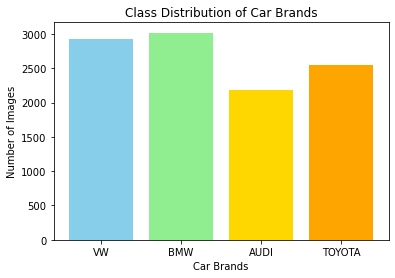

In [5]:
# Count the number of images in each class
VW_count = len(os.listdir(VW_sample_data))
BMW_count = len(os.listdir(BMW_sample_data))
AUDI_count = len(os.listdir(AUDI_sample_data))
TOYOTA_count = len(os.listdir(TOYOTA_sample_data))

# Class labels and counts
class_labels = ['VW', 'BMW', 'AUDI', 'TOYOTA']
class_counts = [VW_count, BMW_count, AUDI_count, TOYOTA_count]

# Create a bar plot
plt.bar(class_labels, class_counts, color=['skyblue', 'lightgreen', 'gold', 'orange'])
plt.xlabel('Car Brands')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Car Brands')
plt.show()

### Parallel Data Preparation for Training

#### Move data from to Train directory and Test Directory

In [6]:
target_dir = "RevisedData/train/"
target1_dir = "RevisedData/test/"

# Define the function to copy files from the main directory to the training directory.
def copy_files(args):
    class_name, class_dir, target_dir, target1_dir, target_count, target1_count = args
    target_class_dir = os.path.join(target_dir, class_name)
    target1_class_dir = os.path.join(target1_dir, class_name)
    os.makedirs(target_class_dir, exist_ok=True)
    os.makedirs(target1_class_dir, exist_ok=True)

    all_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    random.shuffle(all_files)  # Shuffle the order of files

#Train Data    
    current_count = len(os.listdir(target_class_dir))
    files_needed = target_count - current_count

    if current_count >= target_count:
        print(f"Skipping {class_name}, train directory already has {target_count} files.")
        return

    if len(all_files) > files_needed:
        selected_files = set(random.sample(all_files, files_needed))
    else:
        selected_files = set(all_files)

    for file in selected_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(target_class_dir, file))

# Test Data
    current_count = len(os.listdir(target1_class_dir))
    files_needed = target1_count - current_count

    if current_count >= target1_count:
        print(f"Skipping {class_name}, test directory already has {target1_count} files.")
        return

    if len(all_files) > files_needed:
        selected_files = set(random.sample(all_files, files_needed))
    else:
        selected_files = set(all_files)

    for file in selected_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(target1_class_dir, file))
    

In [7]:
def run_parallel_copy(n_processes):
    print(f"Running with {n_processes} processes")
    start_time = time.time()

    with Pool(processes=n_processes) as pool:
        pool.map(copy_files, args)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken with {n_processes} processes: {elapsed_time} seconds\n")
    return elapsed_time

In [8]:
def clear_target_directory(target_dir, target1_dir):
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.makedirs(target_dir, exist_ok=True)
    if os.path.exists(target1_dir):
        shutil.rmtree(target1_dir)
    os.makedirs(target1_dir, exist_ok=True)

In [9]:
classes = ['Volkswagen', 'BMW', 'Audi', 'Toyota']  # Example class names
target_count = 1750
target1_count = 436 

# Prepare the arguments for each class
args = [(class_name, os.path.join(base_dir, class_name), target_dir, target1_dir, target_count, target1_count) for class_name in classes]

# Run the task with different numbers of processes
cpu_counts = [2, 4, 8, 16]
time_taken_train = []

# Run the task with different numbers of processes and store the times
for n in cpu_counts:
    # Clear the target directories before each run
    for class_name in classes:
        clear_target_directory(os.path.join(target_dir, class_name),os.path.join(target1_dir, class_name))
        
    elapsed_time_train = run_parallel_copy(n)
    time_taken_train.append(elapsed_time_train)

Running with 2 processes
Time taken with 2 processes: 183.0558738708496 seconds

Running with 4 processes
Time taken with 4 processes: 103.0777816772461 seconds

Running with 8 processes
Time taken with 8 processes: 91.15491962432861 seconds

Running with 16 processes
Time taken with 16 processes: 84.99930763244629 seconds



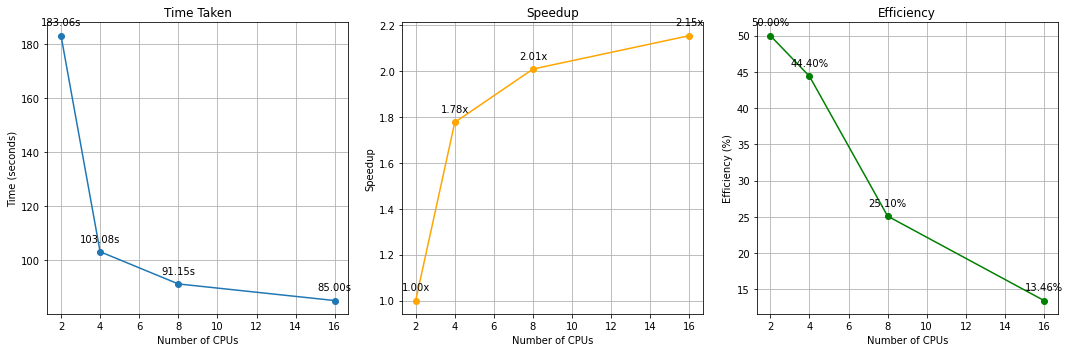

In [10]:
speedup_train = [time_taken_train[0] / t for t in time_taken_train]
efficiency_train = [(s / c) * 100 for s, c in zip(speedup_train, cpu_counts)]

# Plotting the time taken with values displayed
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(cpu_counts, time_taken_train, marker='o')
for i, txt in enumerate(time_taken_train):
    plt.annotate(f"{txt:.2f}s", (cpu_counts[i], time_taken_train[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Time Taken")
plt.xlabel("Number of CPUs")
plt.ylabel("Time (seconds)")
plt.grid(True)

# Plotting the speedup with values displayed
plt.subplot(1, 3, 2)
plt.plot(cpu_counts, speedup_train, marker='o', color='orange')
for i, txt in enumerate(speedup_train):
    plt.annotate(f"{txt:.2f}x", (cpu_counts[i], speedup_train[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Speedup")
plt.xlabel("Number of CPUs")
plt.ylabel("Speedup")
plt.grid(True)

# Plotting the efficiency with values displayed
plt.subplot(1, 3, 3)
plt.plot(cpu_counts, efficiency_train, marker='o', color='green')
for i, txt in enumerate(efficiency_train):
    plt.annotate(f"{txt:.2f}%", (cpu_counts[i], efficiency_train[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Efficiency")
plt.xlabel("Number of CPUs")
plt.ylabel("Efficiency (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
VW_data= r"RevisedData/train/Volkswagen"
print("VW images :\n" ,os.listdir(VW_data)[:5])

BMW_data= r"RevisedData/train/BMW"
print("\nBMW images :\n" ,os.listdir(BMW_data)[:5])

AUDI_data= r"RevisedData/train/Audi"
print("\nAUDI images :\n" ,os.listdir(AUDI_data)[:5])

TOYOTA_data= r"RevisedData/train/Toyota"
print("\nToyota images :\n" ,os.listdir(TOYOTA_data)[:5])

VW images :
 ['002635c660cc97.jpg', '00266f1000f701.jpg', '00774f3b5309fa.jpg', '00792ea6a64a7d.jpg', '00a0a430957440.jpg']

BMW images :
 ['00203ddf0f5cec.jpg', '00c7fd3a3e925c.jpg', '0125409e9a54bb.jpg', '01445e1e7fb693.jpg', '014e4fb06b77b7.jpg']

AUDI images :
 ['00041a0ef10aa2.jpg', '00218c89687073.jpg', '0047c8136dbb78.jpg', '004e5b647d24dc.jpg', '00bb827999e231.jpg']

Toyota images :
 ['0006ab4d109e6e.jpg', '000d005cd4f095.jpg', '00189b8e3f1e03.jpg', '002b7f097120ca.jpg', '005c958a46abf7.jpg']


In [12]:
print("no. of VW images :" ,len(os.listdir(VW_data)))
print("\nno. of BMW images :" ,len(os.listdir(BMW_data)))
print("\nno. of AUDI images :" ,len(os.listdir(AUDI_data)))
print("\nno. of TOYOTA images :" ,len(os.listdir(TOYOTA_data)))

no. of VW images : 1750

no. of BMW images : 1750

no. of AUDI images : 1750

no. of TOYOTA images : 1750


#### Balanced Training Data

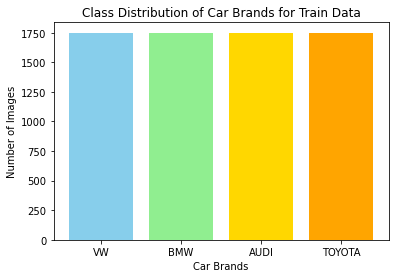

In [13]:
# Count the number of images in each class
VW_count = len(os.listdir(VW_data))
BMW_count = len(os.listdir(BMW_data))
AUDI_count = len(os.listdir(AUDI_data))
TOYOTA_count = len(os.listdir(TOYOTA_data))

# Class labels and counts
class_labels = ['VW', 'BMW', 'AUDI', 'TOYOTA']
class_counts = [VW_count, BMW_count, AUDI_count, TOYOTA_count]

# Create a bar plot
plt.bar(class_labels, class_counts, color=['skyblue', 'lightgreen', 'gold', 'orange'])
plt.xlabel('Car Brands')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Car Brands for Train Data')
plt.show()

In [14]:
VW_test_data= r"RevisedData/test/Volkswagen"
print("VW images :\n" ,os.listdir(VW_test_data)[:5])

BMW_test_data= r"RevisedData/test/BMW"
print("\nBMW images :\n" ,os.listdir(BMW_test_data)[:5])

AUDI_test_data= r"RevisedData/test/Audi"
print("\nAUDI images :\n" ,os.listdir(AUDI_test_data)[:5])

TOYOTA_test_data= r"RevisedData/test/Toyota"
print("\nToyota images :\n" ,os.listdir(TOYOTA_test_data)[:5])

VW images :
 ['003a60f026053f.jpg', '0086ab41a31256.jpg', '00ec6b68f7d60e.jpg', '0187be0bb4d073.jpg', '01a25fd6312b6c.jpg']

BMW images :
 ['00199e658341a8.jpg', '00b1b467b2ed72.jpg', '0125409e9a54bb.jpg', '02c78b02ecdd05.jpg', '0461caf0d7bfe5.jpg']

AUDI images :
 ['004e5b647d24dc.jpg', '00bb827999e231.jpg', '02632dac740923.jpg', '027e0292ddaf17.jpg', '02c2c7ca811eb5.jpg']

Toyota images :
 ['00c0432f5c7185.jpg', '010e01828b66b0.jpg', '01f628bd052a81.jpg', '0205083f8b4754.jpg', '032969edab8f21.jpg']


In [15]:
print("no. of VW images :" ,len(os.listdir(VW_test_data)))
print("\nno. of BMW images :" ,len(os.listdir(BMW_test_data)))
print("\nno. of AUDI images :" ,len(os.listdir(AUDI_test_data)))
print("\nno. of TOYOTA images :" ,len(os.listdir(TOYOTA_test_data)))

no. of VW images : 436

no. of BMW images : 436

no. of AUDI images : 436

no. of TOYOTA images : 436


#### Balanced Test Data

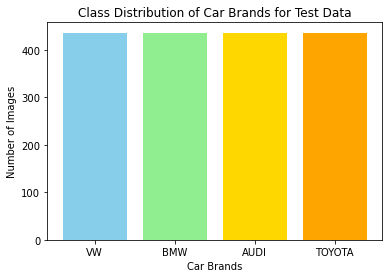

In [16]:
# Count the number of images in each class
VW_count = len(os.listdir(VW_test_data))
BMW_count = len(os.listdir(BMW_test_data))
AUDI_count = len(os.listdir(AUDI_test_data))
TOYOTA_count = len(os.listdir(TOYOTA_test_data))

# Class labels and counts
class_labels = ['VW', 'BMW', 'AUDI', 'TOYOTA']
class_counts = [VW_count, BMW_count, AUDI_count, TOYOTA_count]

# Create a bar plot
plt.bar(class_labels, class_counts, color=['skyblue', 'lightgreen', 'gold', 'orange'])
plt.xlabel('Car Brands')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Car Brands for Test Data')
plt.show()

#### Move data from to Validation directory

In [17]:
def move_images_to_validation(subfolder_args):
    train_dir, val_dir, subfolder, percent_to_move = subfolder_args
    folder_path = os.path.join(train_dir, subfolder)
    target_folder_path = os.path.join(val_dir, subfolder)
    os.makedirs(target_folder_path, exist_ok=True)

    images = os.listdir(folder_path)
    num_to_move = int(len(images) * percent_to_move)
    selected_images = random.sample(images, num_to_move)

    for image in selected_images:
        src_path = os.path.join(folder_path, image)
        dest_path = os.path.join(target_folder_path, image)
        shutil.move(src_path, dest_path)

In [18]:
def parallel_move_to_validation(train_dir, val_dir, subfolders, percent_to_move, n_processes):
    start_time = time.time()
    args = [(train_dir, val_dir, subfolder, percent_to_move) for subfolder in subfolders]

    with Pool(processes=n_processes) as pool:
        pool.map(move_images_to_validation, args)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken with {n_processes} processes: {elapsed_time} seconds\n")
    return elapsed_time

In [19]:
def restore_images_from_val_to_train(train_dir, val_dir, subfolder):
    val_subfolder_path = os.path.join(val_dir, subfolder)
    train_subfolder_path = os.path.join(train_dir, subfolder)

    if not os.path.exists(val_subfolder_path):
        return  # No images to restore

    for image in os.listdir(val_subfolder_path):
        src_path = os.path.join(val_subfolder_path, image)
        dest_path = os.path.join(train_subfolder_path, image)
        shutil.move(src_path, dest_path)  # Move back to train directory

In [20]:
def clear_target_directory(target_dir):
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.makedirs(target_dir, exist_ok=True)

In [21]:
# Set your paths and the percentage of data to move to validation
train_dir = "RevisedData/train"
val_dir = "RevisedData/validation"
percent_to_move = 0.10  # 10% of data moved to validation

time_taken_val = []

for n in cpu_counts:
    if n == 1:
        # Clear the val directories only for the first run
        for class_name in classes:
            clear_target_directory(os.path.join(val_dir, class_name))
    else:
        # Restore images from val to train directory for each class
        for class_name in classes:
            restore_images_from_val_to_train(train_dir, val_dir, class_name)

    # Now run the validation image moving process
    elapsed_time_val = parallel_move_to_validation(train_dir, val_dir, classes, percent_to_move, n)
    time_taken_val.append(elapsed_time_val)

Time taken with 2 processes: 13.334251642227173 seconds

Time taken with 4 processes: 13.495988368988037 seconds

Time taken with 8 processes: 13.146894693374634 seconds

Time taken with 16 processes: 15.373413324356079 seconds



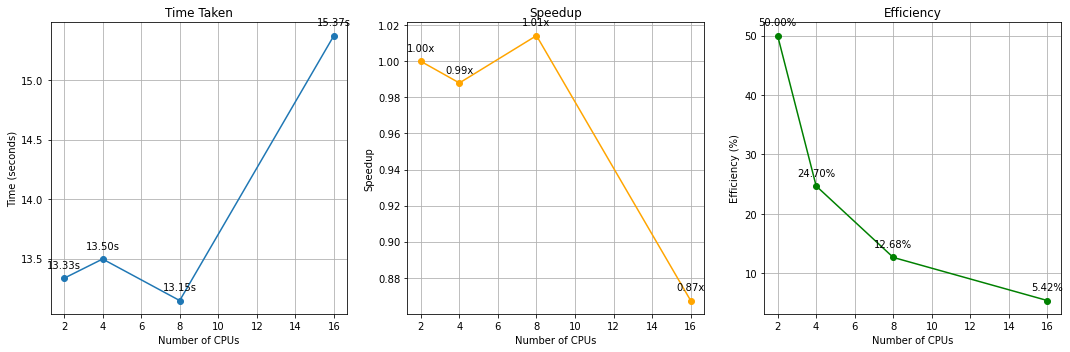

In [22]:
speedup_val = [time_taken_val[0] / t for t in time_taken_val]
efficiency_val = [(s / c) * 100 for s, c in zip(speedup_val, cpu_counts)]

# Plotting the time taken with values displayed
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(cpu_counts, time_taken_val, marker='o')
for i, txt in enumerate(time_taken_val):
    plt.annotate(f"{txt:.2f}s", (cpu_counts[i], time_taken_val[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Time Taken")
plt.xlabel("Number of CPUs")
plt.ylabel("Time (seconds)")
plt.grid(True)

# Plotting the speedup with values displayed
plt.subplot(1, 3, 2)
plt.plot(cpu_counts, speedup_val, marker='o', color='orange')
for i, txt in enumerate(speedup_val):
    plt.annotate(f"{txt:.2f}x", (cpu_counts[i], speedup_val[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Speedup")
plt.xlabel("Number of CPUs")
plt.ylabel("Speedup")
plt.grid(True)

# Plotting the efficiency with values displayed
plt.subplot(1, 3, 3)
plt.plot(cpu_counts, efficiency_val, marker='o', color='green')
for i, txt in enumerate(efficiency_val):
    plt.annotate(f"{txt:.2f}%", (cpu_counts[i], efficiency_val[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Efficiency")
plt.xlabel("Number of CPUs")
plt.ylabel("Efficiency (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

#### Total Data

In [23]:
import os

# Define the directory paths
train_dir = "RevisedData/train/"
val_dir = "RevisedData/validation/"
test_dir = "RevisedData/test/"

# Define the subfolders
subfolders = ['Volkswagen', 'BMW', 'Audi', 'Toyota']

# Initialize a dictionary to store the file counts
file_counts = {
    'train': {subfolder: 0 for subfolder in subfolders},
    'val': {subfolder: 0 for subfolder in subfolders},
    'test': {subfolder: 0 for subfolder in subfolders}
}

# Function to count files in a directory
def count_files_in_directory(directory, subfolder_name):
    subfolder_path = os.path.join(directory, subfolder_name)
    if os.path.exists(subfolder_path):
        return len([f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))])
    else:
        return 0

# Count the number of files in each class within each directory
for subfolder in subfolders:
    file_counts['train'][subfolder] = count_files_in_directory(train_dir, subfolder)
    file_counts['val'][subfolder] = count_files_in_directory(val_dir, subfolder)
    file_counts['test'][subfolder] = count_files_in_directory(test_dir, subfolder)

print(file_counts)

{'train': {'Volkswagen': 1636, 'BMW': 1638, 'Audi': 1606, 'Toyota': 1618}, 'val': {'Volkswagen': 181, 'BMW': 182, 'Audi': 178, 'Toyota': 179}, 'test': {'Volkswagen': 436, 'BMW': 436, 'Audi': 436, 'Toyota': 436}}


#### Sample Images

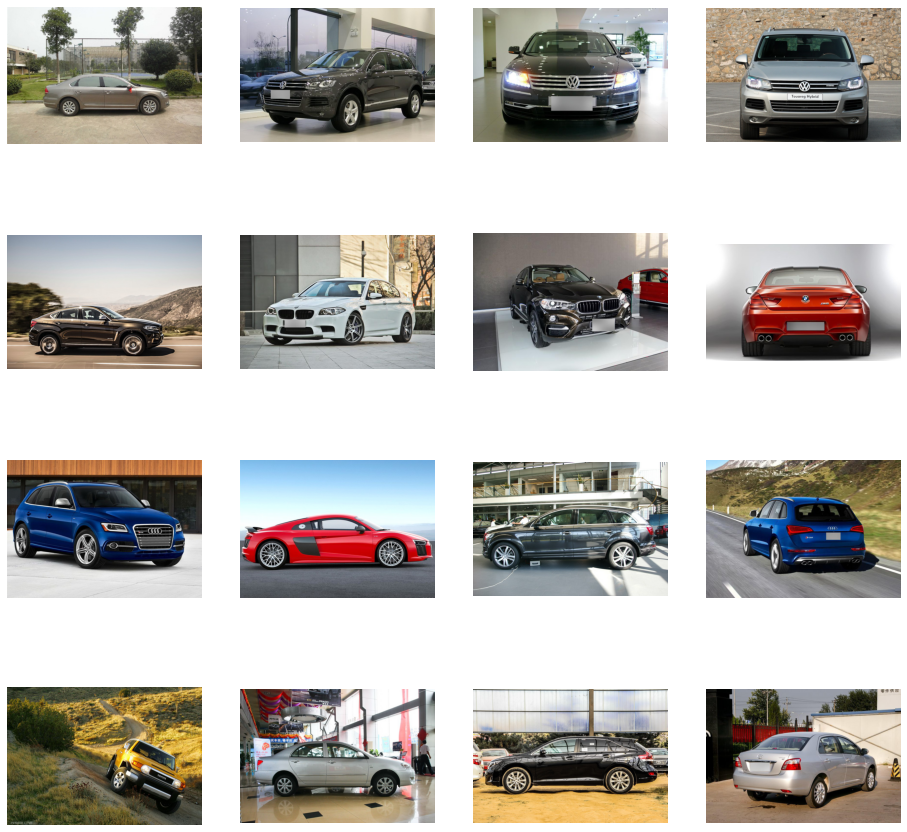

In [24]:
nrows = 4
ncols = 4
pic_index = 0

# Assuming cnv_data, dme_data, drusen_data, normal_data are defined and point to the respective directories
VW_img = [os.path.join(VW_data, image) for image in os.listdir(VW_data)[pic_index:pic_index+ncols]]
BMW_img = [os.path.join(BMW_data, image) for image in os.listdir(BMW_data)[pic_index:pic_index+ncols]]
AUDI_img = [os.path.join(AUDI_data, image) for image in os.listdir(AUDI_data)[pic_index:pic_index+ncols]]
TOYOTA_img = [os.path.join(TOYOTA_data, image) for image in os.listdir(TOYOTA_data)[pic_index:pic_index+ncols]]

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

# Arrange images by class per row
images_by_row = VW_img + BMW_img + AUDI_img + TOYOTA_img

for i, image_path in enumerate(images_by_row):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(image_path)
    plt.imshow(img, cmap='gray')

plt.show()